In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, distinct

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).first()
print(recent_date)

('2017-08-23',)


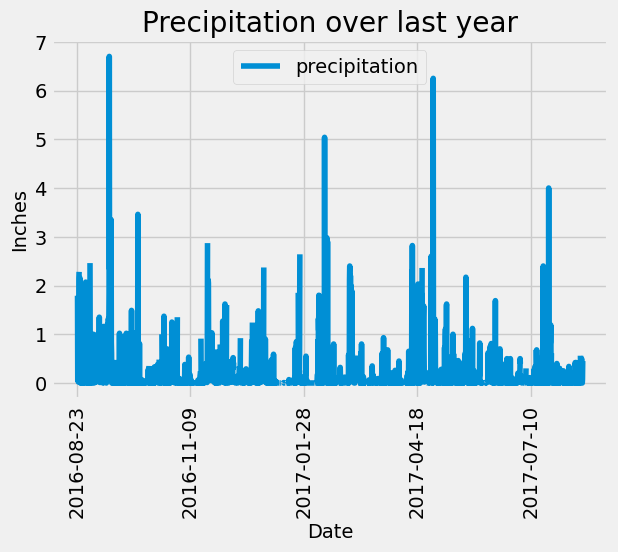

In [33]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
begin_dat = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
in_last_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= begin_dat).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(in_last_year, columns=['date','precipitation'])
df.set_index('date',  inplace=True)

# Sort the dataframe by date
df = df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation over last year')
plt.tight_layout()
plt.xticks(rotation = 90)
plt.show()
ax.figure.savefig('Precipitation_Hawaii.png', bbox_inches='tight')

In [34]:
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [35]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(distinct(Measurement.station))).all()

[(9,)]

In [36]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [Measurement.station, 
       func.count(Measurement.date)]
active_stations = session.query(*sel).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.date).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [37]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station,
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
station_temp_summary = session.query(*sel).\
        filter(Measurement.station == 'USC00519281').\
        group_by(Measurement.station)
for station in station_temp_summary:
    print(station)

('USC00519281', 54.0, 85.0, 71.66378066378067)


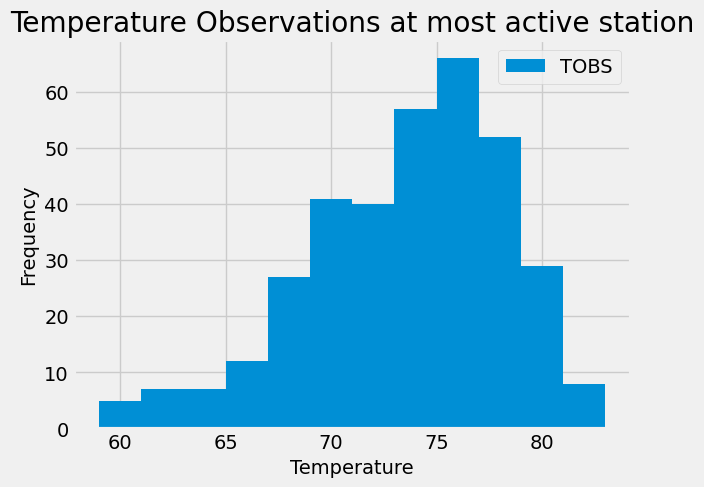

In [21]:
# Using the most active station id
sel = [Measurement.date, 
       Measurement.tobs]
station_temps = session.query(*sel).\
        filter(func.strftime(Measurement.date) >= begin_date, Measurement.station == 'USC00519281').\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()
station_temps_df = pd.DataFrame(station_temps, columns=['Measurement Date', 'Temperature'])

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.hist(station_temps_df['Temperature'],bins=12, density=False, label="TOBS")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.title("Temperature Observations at most active station")
plt.figsize=(10,7)
plt.savefig('Annual_Temps_USC00519281.png',bbox_inches='tight')
plt.show()

# Close Session

In [22]:
# Close Session
session.close()